# Домашнее задание
* Прочитать про методы оптимизации для нейронных сетей https://habr.com/post/318970/
* Реализовать самостоятельно логистическую регрессию
    * Обучить ее методом градиентного спуска
    * Методом nesterov momentum
    * Методом rmsprop
* В качестве dataset'а взять Iris, оставив 2 класса:
    * Iris Versicolor
    * Iris Virginica

In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm_notebook

# Загрузка данных

In [2]:
iris_data = load_iris()

ds = pd.DataFrame(iris_data['data'], columns=iris_data['feature_names'])
ds['target'] = iris_data['target']
ds['target_verb'] = ds['target'].apply(lambda x: iris_data['target_names'][x])
ds = ds[ds['target_verb'].isin(['virginica','versicolor'])]
ds['is_virginica'] = ds['target_verb']=='virginica'
ds.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_verb,is_virginica
50,7.0,3.2,4.7,1.4,1,versicolor,False
51,6.4,3.2,4.5,1.5,1,versicolor,False
52,6.9,3.1,4.9,1.5,1,versicolor,False
53,5.5,2.3,4.0,1.3,1,versicolor,False
54,6.5,2.8,4.6,1.5,1,versicolor,False


# Реализация логистической регрессии

Добавим в данные столбец bias из единиц, который будет отвечать за постоянное смещение модели

In [3]:
ds['bias'] = 1

Выделим X и Y

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split( 
    ds[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'bias']],
    ds['is_virginica'], test_size=0.2)
Y_train.mean(), Y_test.mean()

(0.4875, 0.55)

Вся модель - это вектор из 5 весов

In [5]:
ws = np.random.normal(0,0.01, size=(5,))
ws

array([ 0.01019047,  0.01598845, -0.02325237,  0.00622893,  0.00487262])

Функции для вычисления предсказания модели

In [6]:
def sigm(x):
    return 1/(1+np.exp(-x))

def predict_proba(X, ws):
    return sigm(np.dot(X,ws))

def predict(X, ws, t=0.5):
    return (predict_proba(X,ws)>t).astype(int)

## Градиентный спуск

Loss:
$$J = -\sum_{i=1}^{N} y_i\log (h_\theta(x_i)) + (1 - y_i)\log(1 - h_\theta(x_i))$$

In [7]:
def loss(y, probs):
    return -np.sum(y*np.log2(probs)+(1-y)*np.log2(1-probs))/len(y)

$$h_\theta(x_i) = \frac1{1+e^{-wx_i}}$$

$$\frac{\partial h_\theta(x_i)}{\partial w_j} = \frac{x_{ij}e^{-wx_i}}{(1+e^{-wx_i})^2} = x_{ij}(\frac1{h_\theta(x_i)}-1)h_\theta^2(x_i) = x_{ij}h_\theta(x_i)(1-h_\theta(x_i))$$

grad:
$$\frac{\partial J}{\partial w_j} = -\sum_{i=1}^{N} y_i\frac{\partial \log (h_\theta(x_i))}{\partial w_j} + (1 - y_i)\frac{\partial \log(1 - h_\theta(x_i))}{\partial w_j}$$

$$\frac{\partial \log (h_\theta(x_i))}{\partial w_j} = \frac1{h_\theta(x_i)}\frac{\partial h_\theta(x_i)}{\partial w_j} = x_{ij}(1-h_\theta(x_i))$$

$$\frac{\partial \log (1-h_\theta(x_i))}{\partial w_j} = \frac1{1-h_\theta(x_i)}\frac{\partial (1-h_\theta(x_i))}{\partial w_j} = -x_{ij}h_\theta({x_i})$$

$$\frac{\partial J}{\partial w_j} = -\sum_{i=1}^{N} y_ix_{ij}(1-h_\theta(x_i)) - (1 - y_i)x_{ij}h_\theta({x_i})=-\sum_{i=1}^{N}x_{ij}[y_i-y_ih_\theta(x_i)-h_\theta(x_i)+y_ih_\theta(x_i)] = -\sum_{i=1}^{N}x_{ij}(y_i-h_\theta(x_i))$$

$$ \frac{\partial J}{\partial w_j} = -\sum_{i=1}^{N}x_{ij}(y_i - h(x_i))$$

In [8]:
def grad(X, y, ws):
    probs = predict_proba(X, ws)
    return -np.dot((y-probs),X)/len(y)

In [9]:
def train_step(X, y, ws, l=0.001):
    g = grad(X, y, ws)
    return ws-l*g

In [10]:
wss = []
res_ds = []

for i in tqdm_notebook(range(1000)):
    ws = train_step(X_train,Y_train,wss[-1]) if len(wss)>0 else np.random.normal(0,0.05, size=(5,))
    wss.append(ws)
    train_preds = predict_proba(X_train, ws)
    test_preds = predict_proba(X_test, ws)
    
    res = {'n_iter':i,
          'train_loss':loss(Y_train, train_preds),
          'test_loss':loss(Y_test, test_preds),
          'train_roc':roc_auc_score(Y_train, train_preds),
          'test_roc':roc_auc_score(Y_test, test_preds)}    
    res_ds.append(res)
res_ds = pd.concat([pd.Series(x) for x in res_ds],1).T

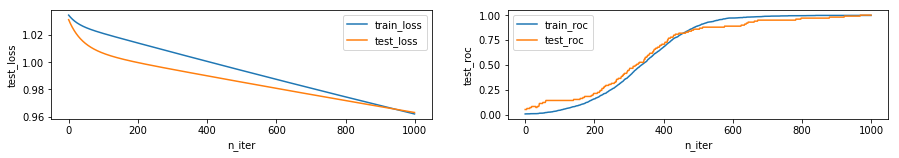

In [11]:
plt.figure(figsize=(15,2))
plt.subplot(121)
sns.lineplot(x='n_iter', y='train_loss',data=res_ds, label='train_loss')
sns.lineplot(x='n_iter', y='test_loss',data=res_ds, label='test_loss')
plt.subplot(122)
sns.lineplot(x='n_iter', y='train_roc',data=res_ds, label='train_roc')
sns.lineplot(x='n_iter', y='test_roc',data=res_ds, label='test_roc')
plt.show()

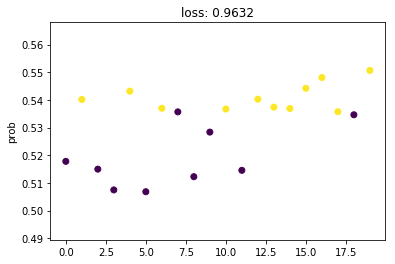

In [12]:
plt.scatter(range(len(X_test)),predict_proba(X_test, ws), c=Y_test)
plt.ylabel('prob')
plt.title(f"loss: {res_ds['test_loss'].values[-1]:.4f}")
plt.show()

## Nesterov momentum

nesterov momentum:

$$v_t = \gamma v_{t-1}+\lambda \frac{dJ}{dw}$$

$$w_t = w_{t-1} - v_t$$

In [13]:
def train_step_nest(X, y, ws, v, l=0.001, gamma=0.9):
    g = grad(X, y, ws)
    v1 = gamma*v+l*g
    return [ws-v1, v1]

In [14]:
wss = []
res_ds = []

for i in tqdm_notebook(range(1000)):
    if len(wss)>0:
        ws, v = train_step_nest(X_train, Y_train, wss[-1], v)
    else:
        ws = np.random.normal(0,0.05, size=(5,))
        v = 1
    wss.append(ws)
    train_preds = predict_proba(X_train, ws)
    test_preds = predict_proba(X_test, ws)
    
    res = {'n_iter':i,
          'train_loss':loss(Y_train, train_preds),
          'test_loss':loss(Y_test, test_preds),
          'train_roc':roc_auc_score(Y_train, train_preds),
          'test_roc':roc_auc_score(Y_test, test_preds)}    
    res_ds.append(res)
res_ds = pd.concat([pd.Series(x) for x in res_ds],1).T

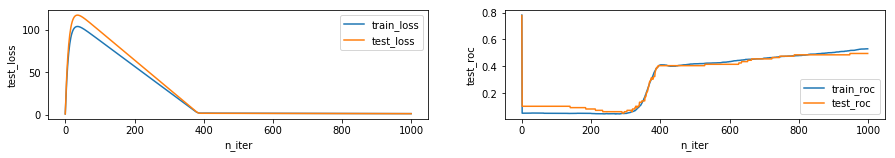

In [15]:
plt.figure(figsize=(15,2))
plt.subplot(121)
sns.lineplot(x='n_iter', y='train_loss',data=res_ds, label='train_loss')
sns.lineplot(x='n_iter', y='test_loss',data=res_ds, label='test_loss')
plt.subplot(122)
sns.lineplot(x='n_iter', y='train_roc',data=res_ds, label='train_roc')
sns.lineplot(x='n_iter', y='test_roc',data=res_ds, label='test_roc')
plt.show()

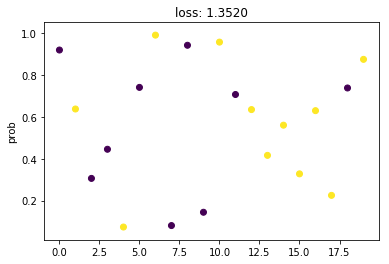

In [16]:
plt.scatter(range(len(X_test)),predict_proba(X_test, ws), c=Y_test)
plt.ylabel('prob')
plt.title(f"loss: {res_ds['test_loss'].values[-1]:.4f}")
plt.show()

## rmsprop

rmsprop:

$$E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma)g_t^2$$

$$w_t = w_{t-1}-\frac{\lambda}{\sqrt{E[g^2]_t+\epsilon}}g_t$$

In [17]:
def train_step_rms(X, y, ws, e, l=0.001, gamma=0.9):
    g = grad(X, y, ws)
    e1 = gamma*e+(1-gamma)*g*g
    return [ws-l/np.sqrt(e+1e-9)*g, e1]

In [18]:
wss = []
res_ds = []

for i in tqdm_notebook(range(1000)):
    if len(wss)>0:
        ws, e = train_step_nest(X_train, Y_train, wss[-1], e, l=0.005)
    else:
        ws = np.random.normal(0,0.05, size=(5,))
        e = 1
    wss.append(ws)
    train_preds = predict_proba(X_train, ws)
    test_preds = predict_proba(X_test, ws)
    
    res = {'n_iter':i,
          'train_loss':loss(Y_train, train_preds),
          'test_loss':loss(Y_test, test_preds),
          'train_roc':roc_auc_score(Y_train, train_preds),
          'test_roc':roc_auc_score(Y_test, test_preds)}    
    res_ds.append(res)
res_ds = pd.concat([pd.Series(x) for x in res_ds],1).T

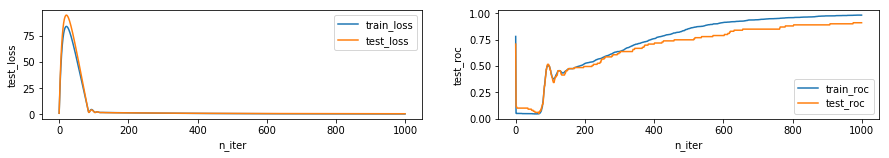

In [19]:
plt.figure(figsize=(15,2))
plt.subplot(121)
sns.lineplot(x='n_iter', y='train_loss',data=res_ds, label='train_loss')
sns.lineplot(x='n_iter', y='test_loss',data=res_ds, label='test_loss')
plt.subplot(122)
sns.lineplot(x='n_iter', y='train_roc',data=res_ds, label='train_roc')
sns.lineplot(x='n_iter', y='test_roc',data=res_ds, label='test_roc')
plt.show()

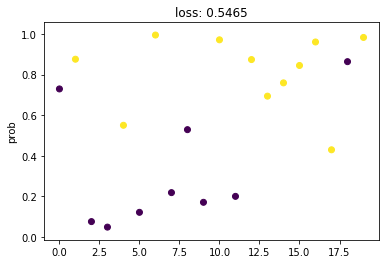

In [20]:
plt.scatter(range(len(X_test)),predict_proba(X_test, ws), c=Y_test)
plt.ylabel('prob')
plt.title(f"loss: {res_ds['test_loss'].values[-1]:.4f}")
plt.show()